In this notebok we'll show some examples of building and searching into spaces.

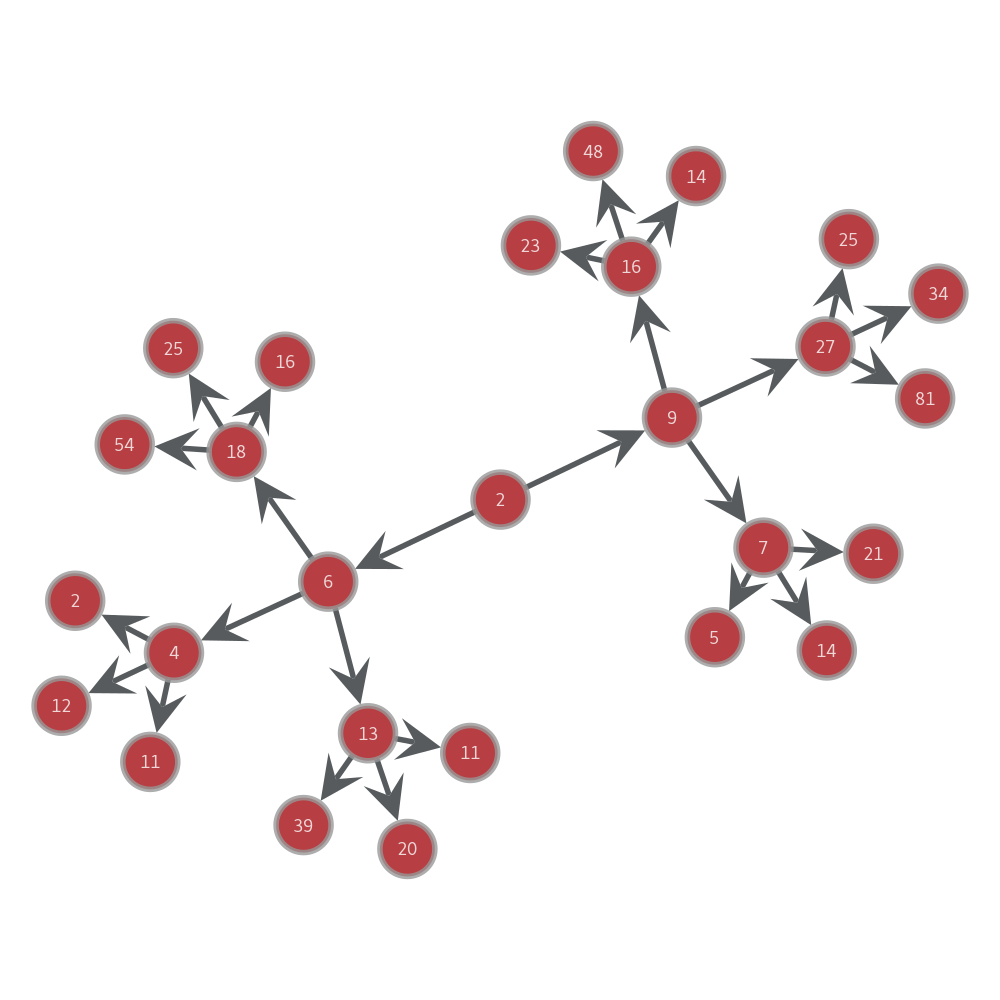

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa3a0229128, at 0x7fa3a02294a8>

In [42]:
from graph_tool.all import *
from numpy import logical_not

DEPTH_LEVEL = 3
INITIAL_STATE = 2
REPEAT_ALLOWED = True

# Rules
RULE_1 = lambda x: x * 3
RULE_2 = lambda x: x + 7
RULE_3 = lambda x: x - 2

def remove_value(l, value=0):
    """
    Remove a value from a list
    :param l: list to be processed
    :param value: value to remove
    :return: list without the value or list if the value is not present
    """
    l.remove(value) if value in l else l
    return l


def get_vertex_by_value(g, value):
    """
    Helper method to get a vertex by its value property 
    :param value: (int) searched value
    :return: (vertex) a vertex if found or None
    """
    for v in g.get_vertices():
        if g.vp.name[v] == value:
            return v
    return


def run_bss(initial, rules, repeat=False, depth=3):
    """
    Creates a graph based on some rules
    :param initial: (int)Initial state
    :param rules: (list) A list of lambda expressions to be used as rules
    :param repeat: (bool) Allow repeated nodes or not
    :param depth: (int) Iterations for the graph
    :return: (Graph) A graph built following the rules
    """
    # Create a graph
    ug = Graph()
    
    # Assign a property to each vertex for storing the value
    vprop_name = ug.new_vertex_property("int")
    ug.vp.name = vprop_name
    
    # Assign a property to each vertex for storing if they have been visited
    vprop_visited = ug.new_vertex_property("bool", False)
    ug.vp.visited = vprop_visited

    # Create the initial vertex
    v1 = ug.add_vertex()
    ug.vp.name[v1] = initial
    # Iterate thru DEPTH_LEVEL times
    for _ in range(depth):
        visited_v = ug.vp.visited.a
        pending = logical_not(visited_v, dtype=bool)
        # TODO: Mask vertices to visit
        for origin in ug.get_vertices():
            visited = ug.vp.visited[origin]
            if visited:
                continue
            # Apply the rules
            new_values = list()
            for rule in rules:
                result = remove_value(list(map(rule, [ug.vp.name[origin]])))
                new_values.extend(result)
            
            # Extend the graph
            for value in new_values:
                if repeat:
                   target = ug.add_vertex()
                else:
                    existing_values = ug.vp.name.a
                    if value in existing_values:
                        target = get_vertex_by_value(ug, value)
                    else:
                        target = ug.add_vertex()
                ug.vp.name[target] = value
                ug.add_edge(origin, target)
            # Mark as visited
            ug.vp.visited[origin] = True
    return ug


# Build the space
ug = run_bss(
    INITIAL_STATE, 
    (RULE_1, RULE_2, RULE_3), 
    REPEAT_ALLOWED, 
    DEPTH_LEVEL,
)

# Represent the graph
graph_draw(
    ug, 
    vertex_text=ug.vp.name, 
    vertex_font_size=18, 
    output_size=(1000, 1000), 
    output="nodes_3_7_2.png",
)

Now, we'll draw the same parameter but avoiding duplicates

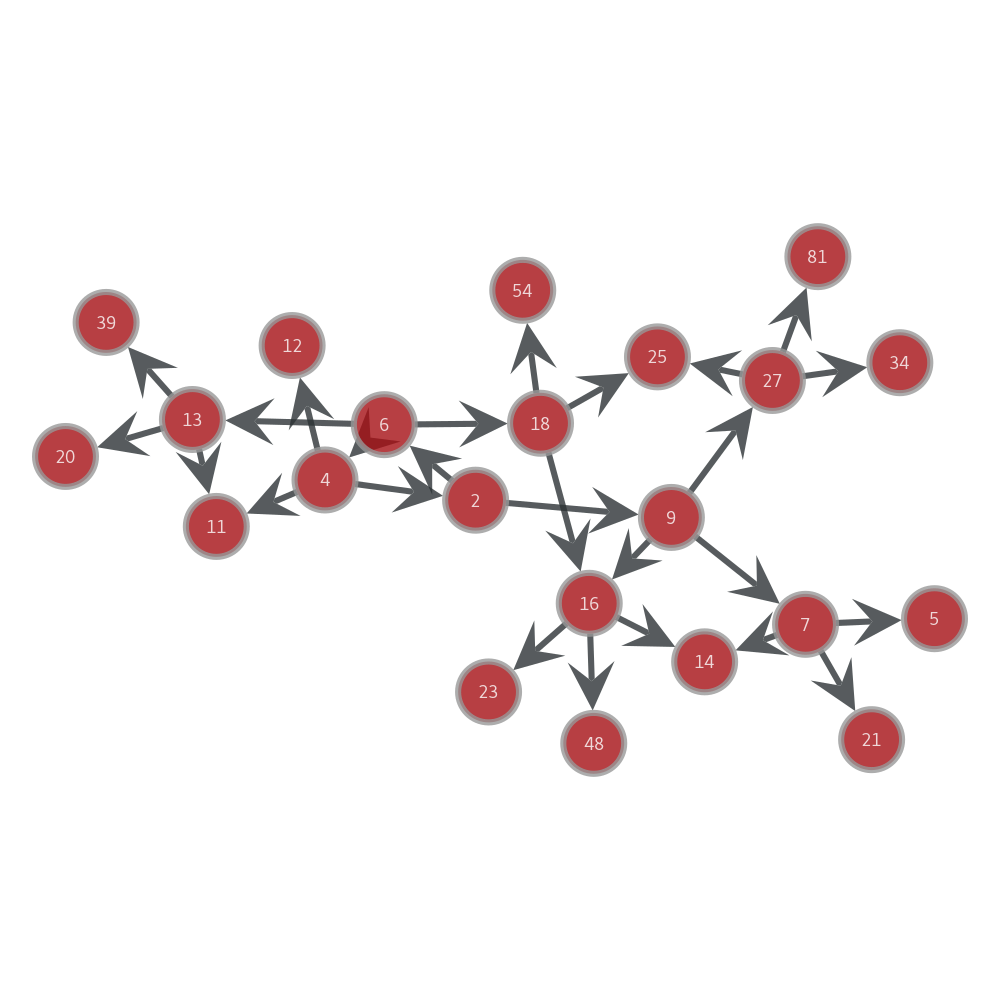

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa3e6d309e8, at 0x7fa3e43dceb8>

In [33]:
REPEAT_ALLOWED = False

# Build the space
ug = run_bss(INITIAL_STATE, (RULE_1, RULE_2, RULE_3), REPEAT_ALLOWED, DEPTH_LEVEL)

# Represent the graph
graph_draw(
    ug, 
    vertex_text=ug.vp.name, 
    vertex_font_size=18, 
    output_size=(1000, 1000), 
    output="nodes_3_7_2_not_repeated.png"
)

In [46]:
RULE_4 = lambda x: x * 7
RULE_5 = lambda x: x - 2
RULE_6 = lambda x: x + 1
RULE_7 = lambda x: x + 11

# Build the space
ug = run_bss(
    initial=8,
    rules=(RULE_4, RULE_5, RULE_6, RULE_7), 
    repeat=False, 
    depth=3,
)

# Represent the graph
graph_draw(
    ug, 
    vertex_text=ug.vp.name, 
    vertex_font_size=18, 
    output_size=(1000, 1000), 
    output="nodes_new_rules.png"
)

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa3e43a7f28, at 0x7fa3a128dfd0>

Load and draw the graph

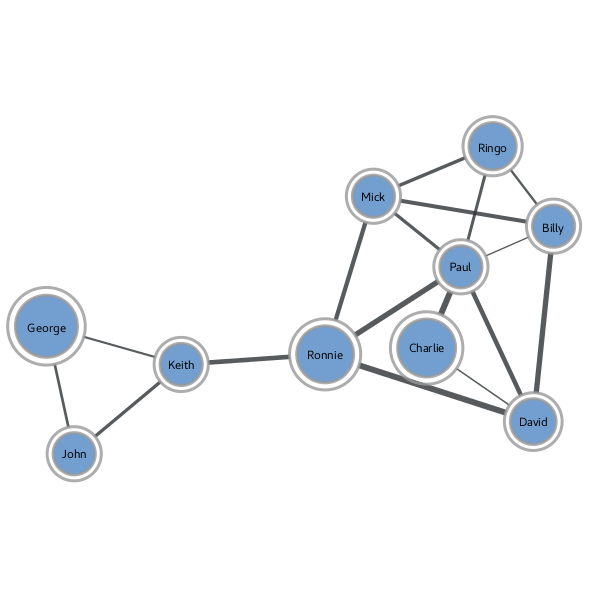

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa3a128db00, at 0x7fa3a128d320>

In [47]:
g = load_graph("/tmp/assets/search_example.xml")
name = g.vp["name"]
weight = g.ep["weight"]
pos = g.vp["pos"]
graph_draw(
    g, pos, vertex_text=name, vertex_font_size=12, vertex_shape="double_circle",
    vertex_fill_color="#729fcf", vertex_pen_width=3,
    edge_pen_width=weight, output="search_example.pdf"
)

In [64]:
class VisitorExample(BFSVisitor):

    def __init__(self, name, pred, dist):
        self.name = name
        self.pred = pred
        self.dist = dist

    def discover_vertex(self, u):
        print("Discovered a new vertex", u)

    def examine_vertex(self, u):
        print("Examined a vertex", u)


    def tree_edge(self, e):
        self.pred[e.target()] = int(e.source())
        self.dist[e.target()] = self.dist[e.source()] + 1


# Add 2 new properties for every vertex
dist = g.new_vertex_property("int")
pred = g.new_vertex_property("int64_t")

# Perform the search with the built-in function
bfs_search(g, g.vertex(0), VisitorExample(name, pred, dist))

# Show the results
print(dist.a)
print(pred.a)

Discovered a new vertex 0
Examined a vertex 0
Discovered a new vertex 6
Discovered a new vertex 4
Discovered a new vertex 3
Discovered a new vertex 7
Examined a vertex 6
Discovered a new vertex 9
Discovered a new vertex 2
Examined a vertex 4
Examined a vertex 3
Discovered a new vertex 1
Examined a vertex 7
Examined a vertex 9
Examined a vertex 2
Examined a vertex 1
Discovered a new vertex 8
Discovered a new vertex 5
Examined a vertex 8
Examined a vertex 5
[0 2 2 1 1 3 1 1 3 2]
[0 3 6 0 0 1 0 0 1 6]


Now, let's iterate through the solution

In [56]:
for e in bfs_iterator(g, g.vertex(0)):
    print(name[e.source()], "->", name[e.target()])


Mick -> Paul
Mick -> Billy
Mick -> Ronnie
Mick -> Ringo
Paul -> David
Paul -> Charlie
Ronnie -> Keith
Keith -> George
Keith -> John


In [66]:
class VisitorExample(DijkstraVisitor):

    def __init__(self, name, time):
        self.name = name
        self.time = time
        self.last_time = 0

    def discover_vertex(self, u):
        print("-->", self.name[u], "has been discovered!")
        self.time[u] = self.last_time
        self.last_time += 1

    def examine_edge(self, e):
        print(
            "edge (%s, %s) has been examined..." %
            (self.name[e.source()], self.name[e.target()]),
        )

    def edge_relaxed(self, e):
        print(
            "edge (%s, %s) has been relaxed..." %
            (self.name[e.source()], self.name[e.target()]),
        )


time = g.new_vertex_property("int")
dist, pred = dijkstra_search(g, weight, g.vertex(0), VisitorExample(name, time))
# Print the results
print(time.a)
print(pred.a)
print(dist.a)

--> Mick has been discovered!
edge (Mick, Paul) has been examined...
edge (Mick, Paul) has been relaxed...
--> Paul has been discovered!
edge (Mick, Billy) has been examined...
edge (Mick, Billy) has been relaxed...
--> Billy has been discovered!
edge (Mick, Ronnie) has been examined...
edge (Mick, Ronnie) has been relaxed...
--> Ronnie has been discovered!
edge (Mick, Ringo) has been examined...
edge (Mick, Ringo) has been relaxed...
--> Ringo has been discovered!
edge (Paul, Ringo) has been examined...
edge (Paul, David) has been examined...
edge (Paul, David) has been relaxed...
--> David has been discovered!
edge (Paul, Ronnie) has been examined...
edge (Paul, Billy) has been examined...
edge (Paul, Mick) has been examined...
edge (Paul, Charlie) has been examined...
edge (Paul, Charlie) has been relaxed...
--> Charlie has been discovered!
edge (Ringo, Mick) has been examined...
edge (Ringo, Billy) has been examined...
edge (Ringo, Paul) has been examined...
edge (Billy, Paul) has 

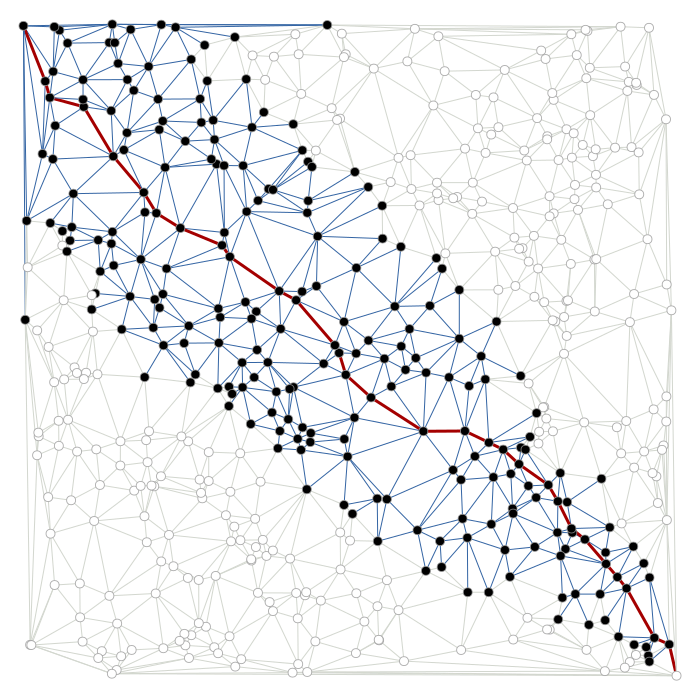

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa3a01aed68, at 0x7fa3a01ae780>

In [73]:
import matplotlib
from math import sqrt
from numpy.random import rand as random


# Heuristic function: euclidean distance
def h(v, target, pos):
    return sqrt(sum((pos[v].a - pos[target].a) ** 2))


class VisitorExample(AStarVisitor):

    def __init__(self, touched_v, touched_e, target):
        self.touched_v = touched_v
        self.touched_e = touched_e
        self.target = target

    def discover_vertex(self, u):
        self.touched_v[u] = True

    def examine_edge(self, e):
        self.touched_e[e] = True

    def edge_relaxed(self, e):
        if e.target() == self.target:
            raise StopSearch()


# Generate 500 pairs of points
points = random(500, 2) * 4

# Set the origin and target
points[0] = [-0.01, 0.01]
points[1] = [4.01, 4.01]

# Generate the space (graph)
g, pos = triangulation(points, type="delaunay")

# Add a new property to the edge to store the weigth
weight = g.new_edge_property("double")

# Fill the weight for every edge
for e in g.edges():
    weight[e] = sqrt(sum((pos[e.source()].a - pos[e.target()].a) ** 2))

# Add a new property for touched vertices
touch_v = g.new_vertex_property("bool")

# Add a property for touched edges
touch_e = g.new_edge_property("bool")

# Set the destination
target = g.vertex(1)

# Perform the search
dist, pred = astar_search(
    g, 
    source=g.vertex(0), 
    weight=weight,
    visitor=VisitorExample(touch_v, touch_e, target),
    heuristic=lambda v: h(v, target, pos)
)

# Add new properties to edges to represent them being either
# part of the solution or not
ecolor = g.new_edge_property("string")
ewidth = g.new_edge_property("double")
ewidth.a = 1

# Paint them in a different color based on if they have been touched or not
for e in g.edges():
    ecolor[e] = "#3465a4" if touch_e[e] else "#d3d7cf"

# Draw the path in red
v = target
while v != g.vertex(0):
    p = g.vertex(pred[v])
    for e in v.out_edges():
        if e.target() == p:
            ecolor[e] = "#a40000"
            ewidth[e] = 3
    v = p

# Finally, draw the graphic
graph_draw(
    g, pos=pos, output_size=(700, 700), vertex_fill_color=touch_v, 
    vcmap=matplotlib.cm.binary, edge_color=ecolor,
    edge_pen_width=ewidth, output="astar-random.pdf",
)

`TODO` Run Dijkstra in the same graph